## Generate training data

In [ ]:
import numpy as np
from cobra.io import load_model
import matplotlib.pyplot as plt
import FBA_data_generation

In [20]:
model = load_model("textbook")
# model = load_model("iJO1366")
vman = "PFK"
file_path = f"fba_data_{vman}.npz"

In [4]:
# anaerobic conditions
# upper bound glucose uptake: 10 mmol/g/h

medium = model.medium
medium["EX_o2_e"] = 0.0
model.medium = medium

model.medium

{'EX_co2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_h_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_pi_e': 1000.0}

In [38]:
# generate new FBA data
X, Y, feasibility_dict = FBA_data_generation.generate_fba_data(model, vman, file_path)

/home/vincent/anaconda3/envs/nnFBA2/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [27]:
# load existing FBA data
data = np.load(file_path, allow_pickle=True)

X = data["X"]
Y = data["Y"]
feasibility_dict = data["feasibility_dict"].item()  # unpack from object dtype

In [28]:
# view infeasible regions
regions = FBA_data_generation.list_infeasible_regions(feasibility_dict)

Infeasible regions for PFK:
  [0.00, 3.00]
  [30.03, 1000.00]


In [29]:
def plot_flux_space(X, Y, vman_id="PFK", output_labels=None):
    """
    Plot exchange fluxes vs vman values.

    Parameters
    ----------
    X : list of [float]
        List of input control fluxes (vman values)
    Y : list of [float]
        Corresponding list of output flux vectors
    vman_id : str
        ID of the manipulated reaction (used for x-axis label)
    output_labels : list of str, optional
        Names of the output fluxes in Y (used for legend)
    """
    X_vals = np.array(X).flatten()
    Y_vals = np.array(Y)

    n_outputs = Y_vals.shape[1]

    # If not provided, create default labels
    if output_labels is None:
        output_labels = [f"Flux {i}" for i in range(n_outputs)]

    plt.figure(figsize=(8, 5))
    for i in range(n_outputs):
        plt.plot(X_vals, Y_vals[:, i], label=output_labels[i])

    plt.xlabel(f"{vman_id} value")
    plt.ylabel("Exchange fluxes")
    plt.title("Flux Space")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


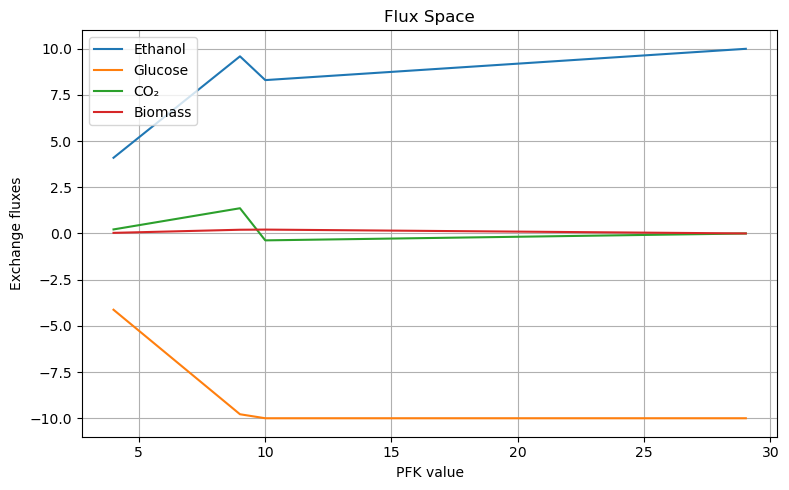

In [30]:
plot_flux_space(
    X, Y,
    vman_id=vman,
    output_labels=["Ethanol", "Glucose", "CO₂", "Biomass"]
)

## Train Surrogate in PyTorch

In [31]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import surrogateNN

In [32]:
x_scaler, y_scaler, X_train, Y_train, X_val, Y_val, X_test, Y_test = surrogateNN.ML_data_prep(X, Y)

model_nn = surrogateNN.SurrogateNN(
    input_dim=X_train.shape[1],
    output_dim=Y_train.shape[1],
    hidden_dim=4
)

loss_fn=nn.MSELoss()

In [33]:
model_nn, train_losses, val_losses = surrogateNN.train_model(
    model_nn, X_train, Y_train, X_val, Y_val,
    loss_fn=loss_fn, epochs=9000, patience=200
)

Epoch 000 | Train Loss: 1.0732 | Val Loss: 1.4098
Epoch 100 | Train Loss: 0.8288 | Val Loss: 1.2871
Epoch 200 | Train Loss: 0.6981 | Val Loss: 1.2323
Epoch 300 | Train Loss: 0.6194 | Val Loss: 1.1915
Epoch 400 | Train Loss: 0.5691 | Val Loss: 1.1525
Epoch 500 | Train Loss: 0.5262 | Val Loss: 1.1035
Epoch 600 | Train Loss: 0.4901 | Val Loss: 1.0684
Epoch 700 | Train Loss: 0.4575 | Val Loss: 1.0303
Epoch 800 | Train Loss: 0.4270 | Val Loss: 0.9928
Epoch 900 | Train Loss: 0.3988 | Val Loss: 0.9602
Epoch 1000 | Train Loss: 0.3746 | Val Loss: 0.9339
Epoch 1100 | Train Loss: 0.3529 | Val Loss: 0.9088
Epoch 1200 | Train Loss: 0.3326 | Val Loss: 0.8861
Epoch 1300 | Train Loss: 0.3147 | Val Loss: 0.8671
Epoch 1400 | Train Loss: 0.2994 | Val Loss: 0.8505
Epoch 1500 | Train Loss: 0.2859 | Val Loss: 0.8354
Epoch 1600 | Train Loss: 0.2740 | Val Loss: 0.8208
Epoch 1700 | Train Loss: 0.2634 | Val Loss: 0.8067
Epoch 1800 | Train Loss: 0.2542 | Val Loss: 0.7933
Epoch 1900 | Train Loss: 0.2455 | Val Los

In [34]:
# save state dict
torch.save(model_nn.state_dict(), f"{vman}_trained_model.pt")

In [35]:
# Rebuild the model architecture (must match original)
model_nn = surrogateNN.SurrogateNN(input_dim=1, hidden_dim=4, output_dim=4)

# Load weights
model_nn.load_state_dict(torch.load(f"{vman}_trained_model.pt"))
model_nn.eval()  # important for inference


SurrogateNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
)

In [7]:
# save full model
#torch.save({
#    "model_state": model_nn.state_dict(),
#    "optimizer_state": optimizer.state_dict(),
#    "epoch": epoch,
#    "train_losses": train_losses,
#}, "checkpoint.pth")

#checkpoint = torch.load("checkpoint.pth")
#model_nn.load_state_dict(checkpoint["model_state"])
#optimizer.load_state_dict(checkpoint["optimizer_state"])

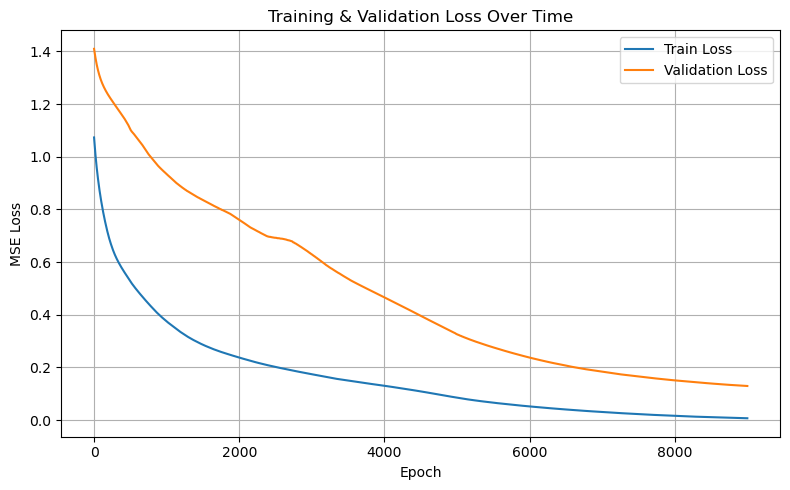

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
model_nn.eval()
with torch.no_grad():
    pred_test = model_nn(X_test)
    loss_test = loss_fn(pred_test, Y_test)

print(f"Final Test MSE: {loss_test.item():.4f}")


Final Test MSE: 0.3091


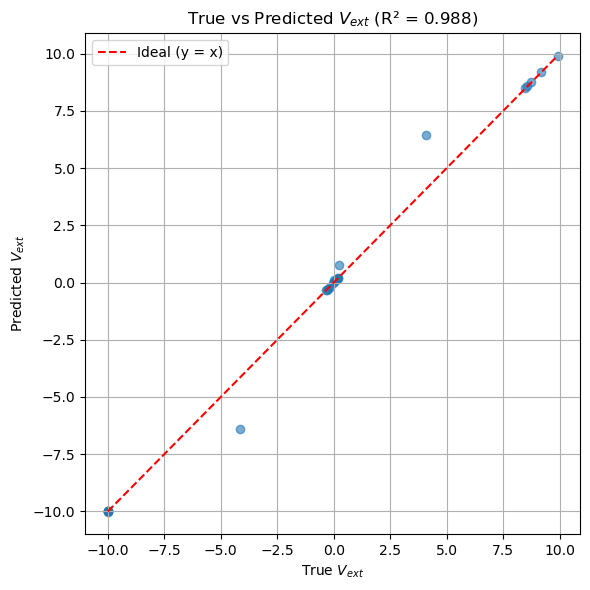

In [38]:
Y_test_np = Y_test.numpy()
pred_test_np = pred_test.numpy()

# Undo scaling
Y_test_true = y_scaler.inverse_transform(Y_test_np)
pred_test_true = y_scaler.inverse_transform(pred_test_np)

# Flatten to plot across all outputs
Y_true_flat = Y_test_true.flatten()
Y_pred_flat = pred_test_true.flatten()

# R² score
r2 = r2_score(Y_true_flat, Y_pred_flat)

# Scatterplot
plt.figure(figsize=(6, 6))
plt.scatter(Y_true_flat, Y_pred_flat, alpha=0.6)
plt.plot([Y_true_flat.min(), Y_true_flat.max()],
         [Y_true_flat.min(), Y_true_flat.max()],
         'r--', label="Ideal (y = x)")
plt.xlabel("True $V_{ext}$")
plt.ylabel("Predicted $V_{ext}$")
plt.title(f"True vs Predicted $V_{{ext}}$ (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Build the Hybrid Model

In [39]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import hybrid_model

In [40]:
def vman_func(t):
    return 1.0  # constant PFK flux
    # return 5.0 + 2.0 * np.sin(0.5 * t)  # sinusoidal control

In [41]:
# initial state: [glucose, ethanol, biomass]
z0 = [10.0, 0.0, 0.01]
tspan = (0, 10)
t_eval = np.linspace(tspan[0], tspan[1], 200)

sol = solve_ivp(
    fun=lambda t, z: hybrid_model.hybrid_ode(t, z, vman_func, model_nn, x_scaler, y_scaler),
    t_span=tspan,
    y0=z0,
    t_eval=t_eval,
    method='RK45'
)

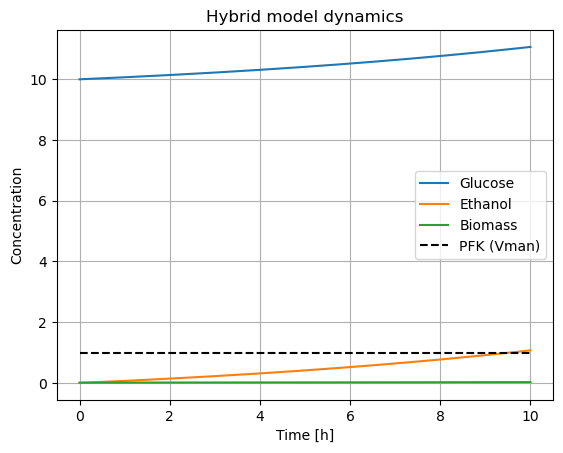

In [42]:
plt.plot(sol.t, sol.y[0], label='Glucose')
plt.plot(sol.t, sol.y[1], label='Ethanol')
plt.plot(sol.t, sol.y[2], label='Biomass')
vman_values = [vman_func(t) for t in sol.t]
plt.plot(sol.t, vman_values, label='PFK (Vman)', linestyle='--', color='black')
plt.xlabel("Time [h]")
plt.ylabel("Concentration")
plt.title("Hybrid model dynamics")
plt.legend()
plt.grid(True)
plt.show()